In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json

# External libraries
from currency_converter import CurrencyConverter
from price_parser import Price

ModuleNotFoundError: No module named 'currency_converter'

# 加载数据

In [3]:
# Load 
# col = pd.read_csv('/kaggle/input/moonsift/collection_info.csv')
# cat = pd.read_csv('/kaggle/input/moonsift/product_categories.csv')
# pub = pd.read_csv("/kaggle/input/moonsift/public_collections_2024_06_to_2024_11_1.csv")

col = pd.read_csv('./collection_info.csv')
cat = pd.read_csv('./product_categories.csv')
pub = pd.read_csv("./public_collections_2024_06_to_2024_11_1.csv")

In [7]:
pub.rename(columns={'hased_user_uid': 'user_id'}, inplace=True)
pub['user_id'] = pd.to_numeric(pub['user_id'], errors='coerce')

# 统计哪个收藏最多

In [16]:
target_user_id = -8929326843455215817
pub1 = pub[pub['user_id'] == target_user_id]
pub1 = pub1.merge(cat[['category', 'link']], on='link')
pub1[['user_id','category','link']].head(5)

,user_id,category,link
0,-8929326843455215817,confectionery,https://www.superdrug.com/fragrance/perfume-fo...
1,-8929326843455215817,jewellery,https://www.regalrose.co.uk/collections/ear-st...
2,-8929326843455215817,bags,https://www.allsaints.com/men/bags/underground...
3,-8929326843455215817,jewellery,https://www.regalrose.co.uk/collections/ear-st...
4,-8929326843455215817,jumpers,https://www.disturbia.co.uk/collections/womens...


In [15]:
count_category = pub1['category'].value_counts()
top_category = count_category.head(1)
print(top_category)

category
jewellery    9
Name: count, dtype: int64


# 按高到低看当前对网站的收藏量

In [19]:
# Get all the information for the user 
web1 = pub[pub['user_id'] == target_user_id]
web1[['user_id','link']]

count_website = (web1['site_uid'].str.replace('https://', '') # Replace with empty string is like removing it
                                .str.replace('www.', '')
                                .str.split('.').str[0] # Separate by . and get the first thing
                                .value_counts()
                                .reset_index())

count_website.head(5)

,site_uid,count
0,disturbia,16
1,regalrose,12
2,killstar,10
3,pand,5
4,allsaints,3


In [20]:
top5_category = (count_category.head(5)
                               .to_frame() # panda series to dataframe 
                               .reset_index()) # category became index at values_count(), switch it to normal column
top5_category.columns = ['category', 'count'] # rename column
top5_category

,category,count
0,jewellery,9
1,shirts,6
2,earrings,5
3,plates,4
4,shorts,4


# 用户在不同月份的消费占比

In [21]:
# Convert all the prices into £ using Price Parsing & Currency Converter libraries 
# Price Parsing convert string containing price and money value into price and currency 
# CurrencyConverter convert prices into EUR, so I will need to reset the default to £

c = CurrencyConverter()

symbol2currency = {
    '£': "GBP",  
    '€': "EUR",    
    '₺': "TRY",
    '$': "USD"
}

def convert2gbp(string): # takes in 'price' from df
    try: 
        # parse string into price and currency
        price = Price.fromstring(string)
        if (price.amount is None or price.currency is None):
            return 0.0 # return 0 when things fail, use a filter later to remove
    
        # map symbol to currency names
        if (price.currency in symbol2currency.keys()):
            price.currency = symbol2currency[price.currency]

        gbp = c.convert(price.amount_float, price.currency, "GBP")
        return round(gbp, 2)
    except: # if there are any errors, just set as 0
        return 0.0

print(convert2gbp("£100")) # control test
print(convert2gbp("$100")) # test
print(convert2gbp("€100")) # test
print(convert2gbp("₺100")) # test
print(convert2gbp("IDR 50000")) # test
print(convert2gbp("MYR 100")) # test
print(convert2gbp("Can$ 100")) # test (fails, it thinks its USD)

100.0
76.12
87.65
1.81
2.28
18.13
76.12


In [35]:
pub['year_month'] = pub['saved_at'].astype(str).str[:7]
pub['price_gbp'] = pub['price'].map(convert2gbp)

# aggregate monthly total spend per user
user2total_price = {}
for uid_tmp, temp_df in pub.groupby("user_id"):
    user2total_price[uid_tmp] = {}
    for year_month, sub_df in temp_df.groupby("year_month"):
        total = sub_df['price_gbp'].sum()
        user2total_price[uid_tmp][year_month] = round(total, 8)

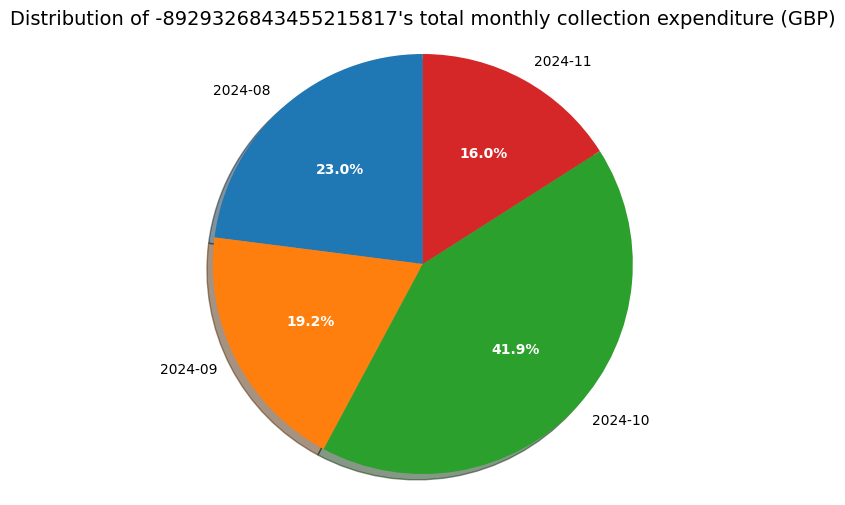

In [32]:
result = user2total_price[target_user_id]

# x: list of months, y: total spend per month (in GBP)
x = list(result.keys())
y = list(result.values())

import matplotlib.pyplot as plt

# Draw a pie chart: each slice is the share of total spend in that month
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(y,labels=x,autopct='%1.1f%%',shadow=True,startangle=90)

# Style the percentage labels: white and bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.title("Distribution of {}'s total monthly collection expenditure (GBP)".format(uid), fontsize=14)
plt.axis('equal')   # equal aspect ratio for a perfect circle
plt.show()

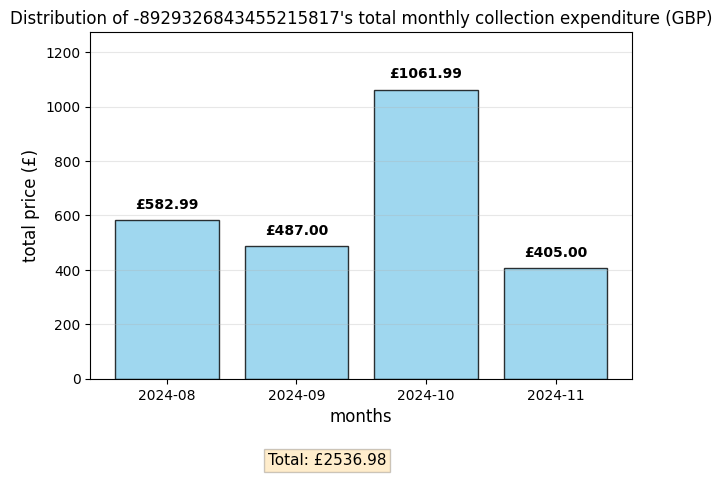

In [33]:
# Bar chart of monthly total spend
import matplotlib.pyplot as plt
import numpy as np

# x: list of months
# y: total spend per month in GBP
bars = plt.bar(x, y, color='skyblue', edgecolor='black', alpha=0.8)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        # use £ and format to 2 decimal places
        plt.text(bar.get_x() + bar.get_width()/2,height + max(y) * 0.03, f'£{height:.2f}',ha='center',va='bottom',fontweight='bold')

# y-axis from 0, with some headroom
plt.ylim(0, max(y) * 1.2)

plt.title("Distribution of {}'s total monthly collection expenditure (GBP)".format(uid))
plt.xlabel('months', fontsize=12)
plt.ylabel('total price (£)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
add_labels(bars)
plt.tight_layout()

total_spend = sum(y)
plt.figtext(0.5, 0.02, f"Total: £{total_spend:.2f}",ha='center', fontsize=11,bbox={'facecolor': 'orange', 'alpha': 0.2, 'pad': 3})

plt.subplots_adjust(bottom=0.2)
plt.show()

# 用户活跃的月份

In [44]:
def first7(x):
    return x[:7]

pub['year_month'] = pub['saved_at'].map(first7)
pub.head(3)

,saved_at,hashed_collection_uid,user_id,site_uid,link,description,price,best_image_url,original_image,product_image,registry_collection,vector_string,year_month,price_gbp
0,2024-08-05 08:46:29.404 UTC,-7482265587325576823,-5871733243031682059,www.converse.ph,https://www.converse.ph/run-star-hike-lugged-4...,Buy Run Star Hike Canvas Platform Shoes - Blac...,IDR 0.00,https://www.converse.ph/media/catalog/product/...,https://www.converse.ph/media/catalog/product/...,moonimage_xEzNylnA0sslHRzNet7f,False,"[0.051450341939926147,-0.21053431928157806,-0....",2024-08,0.00
1,2024-10-04 05:05:04.88 UTC,-2995264064190504646,-6539087108041660150,littleyoyo.ca,https://littleyoyo.ca/products/chunky-clock-pu...,Hape - Chunky Clock Puzzle – littleyoyo.ca,USD 17.00,https://littleyoyo.ca/cdn/shop/products/E1622_...,https://littleyoyo.ca/cdn/shop/products/E1622_...,moonimage_d7odB7NKQ75Q15Hj8uFr,True,"[0.043126579374074936,-0.015072589740157127,-0...",2024-10,12.94
2,2024-10-10 00:33:51.313 UTC,1787838775367910769,-1341189435363493307,a.co,https://a.co/d/d84agNx,Amazon.com: Konssy Muslin Baby Burp Cloths Set...,$16.14 16 . 14,https://m.media-amazon.com/images/I/518o1YcU7T...,https://m.media-amazon.com/images/I/518o1YcU7T...,moonimage_4zKXDMjjwvdmAehGvRhN,True,"[0.051432691514492035,0.0905093103647232,-0.05...",2024-10,0.00


In [46]:
d = {}
for uid, temp_df in pub.groupby("user_id"):
    d[uid] = {}
    for year_month, sub_df in temp_df.groupby("year_month"):
        d[uid][year_month] = sub_df.shape[0]

# Example: get one user's month-level counts

# For each user, for each year month, get the values count of collections
user_yr_month_count = pub.groupby(["user_id", "year_month"]).size().to_frame().reset_index()
user_yr_month_count.columns = ["user_id", "year_month", 'count']
user_yr_month_count[user_yr_month_count['user_id'] == target_user_id]

,user_id,year_month,count
162,-8929326843455215817,2024-08,17
163,-8929326843455215817,2024-09,9
164,-8929326843455215817,2024-10,18
165,-8929326843455215817,2024-11,6


<Axes: xlabel='year_month', ylabel='count'>

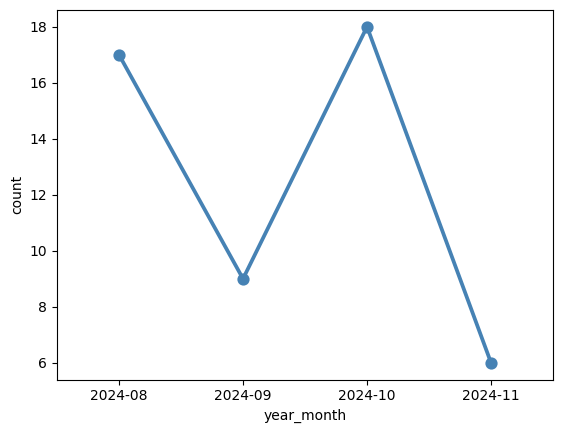

In [48]:
# Plot the activity of each month according to collections number
extracted_df = user_yr_month_count[user_yr_month_count['user_id'] == target_user_id]
sns.pointplot(data=extracted_df, x='year_month', y='count', color='steelblue')

# ItemCF

Item-based Collaborative Filtering

If User1 likes item A, and A is similar to B, then recommend B to User1.Try to find top-3 similar items for each item

Group by site_uid to build a set of users for each site, and drop sites with fewer than 2 users.

In [50]:
#Step 1: users per item
site2user_list = {}
for site, temp_df in pub.groupby("site_uid"):
    # 当前 site 被哪些用户收藏 / users who interacted with this site
    temp = set(temp_df['user_id'].tolist())
    # 只保留至少有 2 个用户的商品，过滤掉太冷门的 / keep sites with at least 2 users
    if len(temp) >= 2:
        site2user_list[site] = temp
# print(site2user_list)    

Use Jaccard similarity on user sets to find top-3 similar sites for each site and store them in dict d.

In [51]:

#Step 2: top-3 similar sites

from tqdm import tqdm
d = {}
for site, user_list in tqdm(site2user_list.items()):
    result = []
    for candidate_site, candidate_user_list in site2user_list.items():
        if site == candidate_site:
            continue  #skip self

        # Jaccard：
        sim = len(user_list & candidate_user_list) / len(user_list | candidate_user_list)
        result.append([sim, candidate_site])

    # sort by similarity and keep top 3
    result = sorted(result, key=lambda x: x[0], reverse=True)
    result = result[:3]
    d[site] = result
    
#print(d)

100%|██████████████████████████████████████| 2300/2300 [00:15<00:00, 143.81it/s]


For the target user, get all visited sites, expand them via their similar-site lists,
aggregate similarity scores for each candidate site, filter out already visited ones, and sort to get the final ranked recommendations.

In [53]:
#Step 3: generate recommendations for a user
# 该用户访问/收藏过的 site 集合 / all sites visited by this user
uid_visited_site = set(pub[pub['user_id'] == uid]['site_uid'].tolist())
# print(uid_visited_site)

# 汇总所有候选推荐（带相似度分数） / collect all candidate recommendations
l1 = []
for site in uid_visited_site:
    temp = d.get(site)
    if temp is not None:
        # temp 是 [[score, site], ...] / temp looks like [[score, site], ...]
        l1.extend(temp)


# 去重并累加分数 / deduplicate and aggregate scores
recommend_site = {}
# [[score, site], [score, site], [score, site], ....]
for x in l1:
    # 不推荐用户已经访问过的 site / skip sites already visited
    if x[1] not in uid_visited_site: 
        if x[1] in recommend_site:
            recommend_site[x[1]] += x[0]# 多次命中的分数累加 / accumulate scores if multiple hits
        else:
            recommend_site[x[1]] = x[0]
# print(recommend_site)

# 按总分从高到低排序 / sort candidates by total score
recommend_site = sorted(recommend_site.items(), key=lambda x: x[1], reverse=True)

for site, score in recommend_site:
    print(f"site: {site}, score:{score}")

site: thecbpstore.com, score:0.3333333333333333
site: niwaki.com, score:0.25
site: webuy.com, score:0.08333333333333333
site: anthropologie.com, score:0.02867383512544803
site: etsy.com, score:0.02320185614849188
site: ikea.com, score:0.022508038585209004
site: argos.co.uk, score:0.013157894736842105


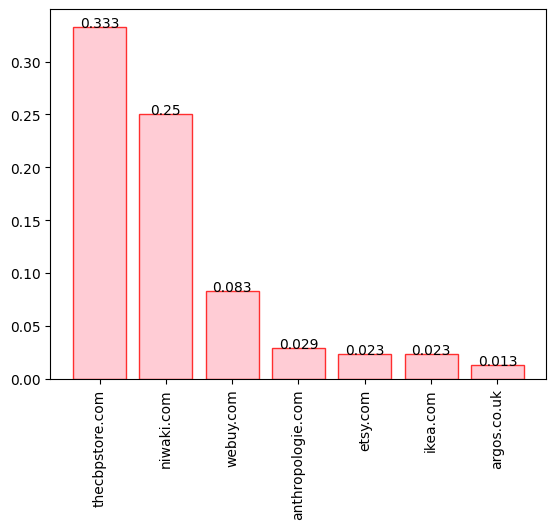

In [54]:
# Step 4: visualize top-10 recommendations
import matplotlib.pyplot as plt
import numpy as np

# 只展示前 10 个推荐 / take top 10
recommend_site = recommend_site[:10]
all_sites = [x[0] for x in recommend_site]
all_scores = [round(x[1],3) for x in recommend_site]

plt.bar(all_sites, all_scores, color='pink', edgecolor='red', alpha=0.8)


# 在柱子上标注分数 / annotate bars with scores
for site, score in zip(all_sites, all_scores):
    plt.text(site, score, score, ha='center')
plt.xticks(rotation=90)
plt.show()

# 类别协同过滤 + 热门商品（itemCF+best selling goods）

Define a fixed list of category names to label products, covering clothing, furniture, accessories, etc.

In [55]:
# Vector <= Item: 8 liked items -> 8 vectors -> similarity search on ~1M items.
# 1. 定义离散类别标签 / Define discrete category labels
categories = ["Sweater", "Shirt", "Trousers", "Dress", "Skirt", "Coat", "Jacket", "Jeans", "Shorts", "Blouse", "T-shirt", "Polo", "Hoodie", "Suit", "Underwear", "Socks", "Chair", "Sofa", "Table", "Desk", "Bed", "Dresser", "Wardrobe", "Bookshelf", "Cabinet", "Ottoman", "Stool", "Bench", "Nightstand", "Recliner", "Coffee Table", "Dining Table", "Perfume", "Watch", "Belt", "Sunglasses", "Wallet", "Hat", "Scarf", "Gloves", "Handbag", "Backpack", "Necklace", "Bracelet", "Earrings", "Ring", "Keychain", "Umbrella", "Shoe"]
len(categories)

49

Use a remote Fashion-CLIP service to embed category names into vectors, preparing for mapping item vectors to categories.

In [56]:
#2. 调用向量服务为类别编码 / Encode categories via vector service
#!pip install google
#
#import json
#import requests
#import google.auth.transport.requests
#import google.oauth2.id_token
#from google.oauth2 import service_account
#from google.auth import default
#from urllib import request
#from urllib.parse import urlparse, urlunparse
#import base64
#import numpy as np
#
#VECTORIZER_URL = "https://fashion-clip-649201865686.europe-west2.run.app/embeddings"
#
#def get_vector_from_text(text: list[str]):
#    """调用远程服务，把文本列表编码成向量 / Call remote service to encode a list of texts into vectors."""
#    req = request.Request(
#        f"{VECTORIZER_URL}/texts",
#        json.dumps({'data': text}).encode('utf-8')
#    )
#    req.add_header('Content-Type', 'application/json')
#    response = request.urlopen(req)
#    return json.loads(response.read())['data']
#    
#category_vectors = get_vector_from_text(categories) 
#category_vectors  # 可选：检查返回结果 / optional: inspect raw vectors

For each category, compute dot-product similarity with all categories, pick the most similar other category, and store it in oriCategory2simCategory.

In [57]:
#3. Load vectors & build similar-category map

import json
import numpy as np

# Load pre-saved category vectors aligned with `categories`
category_vec = json.load(open("./category_vec.json", 'r', encoding='utf8'))
category_vec = np.array(category_vec)
print(category_vec.shape)

oriCategory2simCategory = {}
for i in range(category_vec.shape[0]):
    # Dot product with all categories (similarity measure)
    dot_products = np.dot(category_vec, category_vec[i])
    # sort indices descending by similarity
    res = np.argsort(dot_products)[::-1]
    # pick second best (self is always top1)
    top_category = res[1]
    # print('ori label:', categories[i], "top1 label:", categories[top_category])
    oriCategory2simCategory[categories[i]] = categories[top_category]

print(oriCategory2simCategory)

(49, 512)
{'Sweater': 'Hoodie', 'Shirt': 'T-shirt', 'Trousers': 'Jeans', 'Dress': 'Shirt', 'Skirt': 'Shorts', 'Coat': 'Jacket', 'Jacket': 'Coat', 'Jeans': 'Trousers', 'Shorts': 'Skirt', 'Blouse': 'Shirt', 'T-shirt': 'Shirt', 'Polo': 'Shirt', 'Hoodie': 'Sweater', 'Suit': 'Jacket', 'Underwear': 'Socks', 'Socks': 'Shoe', 'Chair': 'Stool', 'Sofa': 'Chair', 'Table': 'Desk', 'Desk': 'Table', 'Bed': 'Sofa', 'Dresser': 'Cabinet', 'Wardrobe': 'Dresser', 'Bookshelf': 'Wardrobe', 'Cabinet': 'Desk', 'Ottoman': 'Shoe', 'Stool': 'Chair', 'Bench': 'Desk', 'Nightstand': 'Dresser', 'Recliner': 'Chair', 'Coffee Table': 'Table', 'Dining Table': 'Table', 'Perfume': 'Cabinet', 'Watch': 'Shoe', 'Belt': 'Bracelet', 'Sunglasses': 'Necklace', 'Wallet': 'Belt', 'Hat': 'Shirt', 'Scarf': 'Socks', 'Gloves': 'Socks', 'Handbag': 'Shoe', 'Backpack': 'Jacket', 'Necklace': 'Keychain', 'Bracelet': 'Belt', 'Earrings': 'Necklace', 'Ring': 'Bracelet', 'Keychain': 'Socks', 'Umbrella': 'Coat', 'Shoe': 'Watch'}


Compute similarity between each item embedding and all category vectors, and assign the best-matching category as the item label.

In [58]:
#4. Assign category label from vectors向量打类别标签 

from tqdm import tqdm

# 把字符串形式的向量转成 numpy 向量
# Convert string-encoded vectors to real numpy arrays
pub['vector'] = pub['vector_string'].apply(lambda x:np.array(x[1:-1].split(",")).astype(float))

all_category = []
# 对每个商品向量，找出最相似的类别向量
# For each product vector, find the most similar category vector
for product_index in tqdm(range(pub.shape[0])):
    dot_products = np.dot(category_vec, pub['vector'].iloc[product_index])
    top_category = categories[np.argmax(dot_products)]
    all_category.append(top_category)


# 为每个商品添加 label 列
# Add a `label` column for each product
pub['label'] = all_category

pub.head(3)

100%|██████████████████████████████████| 92774/92774 [00:04<00:00, 20929.05it/s]


,saved_at,hashed_collection_uid,user_id,site_uid,link,description,price,best_image_url,original_image,product_image,registry_collection,vector_string,year_month,price_gbp,vector,label
0,2024-08-05 08:46:29.404 UTC,-7482265587325576823,-5871733243031682059,www.converse.ph,https://www.converse.ph/run-star-hike-lugged-4...,Buy Run Star Hike Canvas Platform Shoes - Blac...,IDR 0.00,https://www.converse.ph/media/catalog/product/...,https://www.converse.ph/media/catalog/product/...,moonimage_xEzNylnA0sslHRzNet7f,False,"[0.051450341939926147,-0.21053431928157806,-0....",2024-08,0.00,"[0.05145034193992615, -0.21053431928157806, -0...",Shoe
1,2024-10-04 05:05:04.88 UTC,-2995264064190504646,-6539087108041660150,littleyoyo.ca,https://littleyoyo.ca/products/chunky-clock-pu...,Hape - Chunky Clock Puzzle – littleyoyo.ca,USD 17.00,https://littleyoyo.ca/cdn/shop/products/E1622_...,https://littleyoyo.ca/cdn/shop/products/E1622_...,moonimage_d7odB7NKQ75Q15Hj8uFr,True,"[0.043126579374074936,-0.015072589740157127,-0...",2024-10,12.94,"[0.043126579374074936, -0.015072589740157127, ...",Watch
2,2024-10-10 00:33:51.313 UTC,1787838775367910769,-1341189435363493307,a.co,https://a.co/d/d84agNx,Amazon.com: Konssy Muslin Baby Burp Cloths Set...,$16.14 16 . 14,https://m.media-amazon.com/images/I/518o1YcU7T...,https://m.media-amazon.com/images/I/518o1YcU7T...,moonimage_4zKXDMjjwvdmAehGvRhN,True,"[0.051432691514492035,0.0905093103647232,-0.05...",2024-10,0.00,"[0.051432691514492035, 0.0905093103647232, -0....",Socks


Based on the assigned labels, count how often each item is collected (after user-level deduplication) and get the top-3 hottest items for each category.

In [60]:
#5. 统计每个类别下最热门的商品 / Top products per category

from collections import Counter

categroy2topProduct = {}
for cate in categories:
    # 同一用户对同一商品只算一次
    # Deduplicate by (user, link)
    df_dup = pub.drop_duplicates(subset=['user_id', "link"])

    # 取出该类别下所有商品的 link
    # Get all links under this category
    link_list = df_dup[df_dup['label'] == cate]['link'].tolist()

    # 统计每个 link 出现次数，并取前 3 名
    # Count link frequency and keep top-3
    d = dict(Counter(link_list))
    temp = sorted(d.items(), key=lambda x: x[1], reverse=True)
    temp = temp[:4]
    categroy2topProduct[cate] = temp
# print(categroy2topProduct)

# Test: check top-3 products for "Sweater"
categroy2topProduct['Sweater']

[('https://www2.hm.com/en_gb/productpage.1245736004.html', 4),
 ('https://us.brandymelville.com/products/eva-cable-knit-sweater', 3),
 ('https://www.urbanoutfitters.com/shop/bdg-skylar-oversized-cable-knit-sweater?',
  3),
 ('https://www.hollisterco.com/shop/us/p/oversized-cable-knit-half-zip-sweater-57491321?categoryId=12627&faceout=model&seq=05',
  3)]

In [62]:
# 6. Recommend categories & items
# 用户已经访问/收藏过的类别集合
# Categories the user has already interacted with
uid_visited_category = set(pub[pub['user_id'] == target_user_id]['label'].tolist())
# print(uid_visited_catgory)

recommend_category2count = {}
for category in uid_visited_category:
    # 找到该类别最相似的另一个类别
    # Get the most similar *other* category
    sim_category = oriCategory2simCategory.get(category)

    # 不推荐用户已经访问过的类别
    # Skip categories the user has already visited
    if sim_category is not None and sim_category not in uid_visited_category:
        if sim_category in recommend_category2count:
            recommend_category2count[sim_category] += 1
        else:
            recommend_category2count[sim_category] = 1


# 按被“命中次数”排序，取 top 3 推荐类别
# Sort by hit count and keep top-3 recommended categories
recommend_category2count = sorted(recommend_category2count.items(), key=lambda x: x[1], reverse=True)[:4] 

# Print recommended categories, their weights, and top-3 product links
for label, weight in recommend_category2count:
    print("category:{}, weight: {}, top3 link: {}".format(label, weight, categroy2topProduct[label]))

category:Socks, weight: 2, top3 link: [('https://www.aloyoga.com/products/a0480u-unisex-half-crew-throwback-sock-white-black', 6), ('https://www.rhodeskin.com/products/peptide-lip-tint-raspberry-jelly', 5), ('https://www.ulta.com/p/halo-glow-powder-puff-pimprod2035997?sku=2603660', 4), ('https://us.jellycat.com/amuseables-pickle/', 4)]
category:Belt, weight: 2, top3 link: [('https://www.ulta.com/p/clear-brow-lash-mascara-xlsImpprod14521111?sku=2500421', 2), ('https://ulta.cashstar.com/store/recipient?locale=en-us', 2), ('https://www.marksandspencer.com/leather-casual-belt/p/clp60587140?colour=BROWN&extid=ps_ps-gpla-pmax_bing_mw_ch_-_UK_-_-_ssc&gclid=1b02dd88451b1625950abb2e35e50161&gclsrc=3p.ds&msclkid=1b02dd88451b1625950abb2e35e50161', 2), ('https://www.sephora.com/product/refy-beauty-mini-brow-sculpt-and-sculpt-face-primer-set-P512795', 2)]
category:Coat, weight: 2, top3 link: [('https://www.ugg.com/women-slippers/tasman-slipper/5955.html', 11), ('https://www.ugg.com/women-slippers/t

# 活跃的时间段

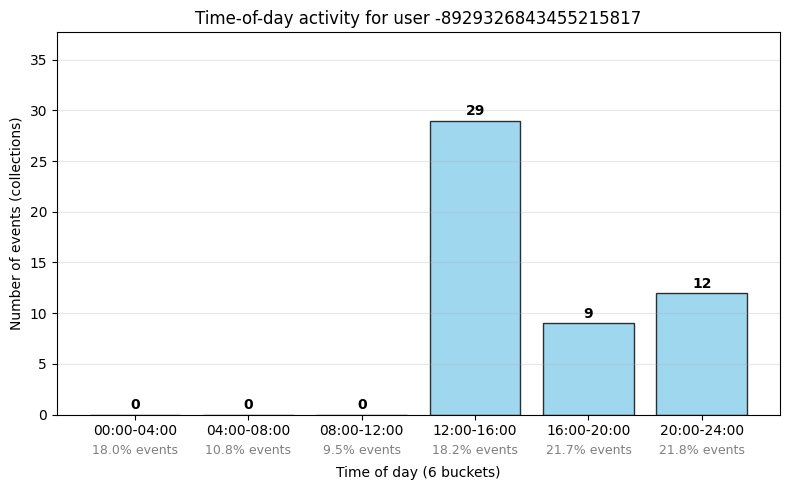

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

uid = -8929326843455215817

bucket_order = ["00:00-04:00", "04:00-08:00", "08:00-12:00",
                "12:00-16:00", "16:00-20:00", "20:00-24:00"]

# 1. Robust datetime parsing
# convert 'saved_at' to datetime, allow mixed formats, keep UTC, coerce bad rows to NaT
pub['saved_at_dt'] = pd.to_datetime(pub['saved_at'],errors='coerce')

# drop rows where datetime is missing (cannot be parsed)
pub = pub.dropna(subset=['saved_at_dt'])

# year-month string
pub.loc[:, 'year_month'] = pub['saved_at_dt'].dt.strftime('%Y-%m')

# pick last 6 months in the dataset
all_months = sorted(pub['year_month'].dropna().unique())
last_6_months = all_months[-6:]
df_6m = pub[pub['year_month'].isin(last_6_months)].copy()

# 2. hour -> 6 time buckets (handle NaN hour explicitly)
def map_hour_to_bucket(hour):
    # if hour is NaN, return None so we can drop it later
    if pd.isna(hour):
        return None
    hour = int(hour)
    if 0 <= hour < 4:
        return "00:00-04:00"
    elif 4 <= hour < 8:
        return "04:00-08:00"
    elif 8 <= hour < 12:
        return "08:00-12:00"
    elif 12 <= hour < 16:
        return "12:00-16:00"
    elif 16 <= hour < 20:
        return "16:00-20:00"
    else:
        return "20:00-24:00"

df_6m.loc[:, 'time_bucket'] = df_6m['saved_at_dt'].dt.hour.map(map_hour_to_bucket)
df_6m = df_6m.dropna(subset=['time_bucket'])  # drop rows with invalid bucket

# 3. counts for target user & global share

# target user's event counts in the 6 time buckets
# NOTE: you already renamed hased_user_uid -> user_id earlier, so use 'user_id' here
user_df = df_6m[df_6m['user_id'] == uid]
user_bucket_counts = user_df['time_bucket'].value_counts().reindex(bucket_order, fill_value=0)

# global event counts in each time bucket (all users)
global_bucket_counts = df_6m['time_bucket'].value_counts().reindex(bucket_order, fill_value=0)

# global share (% of all events), keep 1 decimal place
bucket_event_pct = (global_bucket_counts / global_bucket_counts.sum() * 100).round(1)

# 4. visualization

x = bucket_order
y = user_bucket_counts.values

plt.figure(figsize=(8, 5))

bars = plt.bar(x, y, color='skyblue', edgecolor='black', alpha=0.8)

# label each bar with this user's count
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,height + 0.2,f"{int(height)}",ha='center', va='bottom', fontweight='bold')

max_height = max(y) if len(y) > 0 else 1
plt.ylim(0, max_height * 1.3)

# under each bar, show: what % of all events happen in this bucket
for i, pct in enumerate(bucket_event_pct):
    plt.text(i,-max_height * 0.1,f"{pct:.1f}% events",ha='center', va='top', fontsize=9, color='gray')

plt.title(f"Time-of-day activity for user {uid}")
plt.xlabel("Time of day (6 buckets)", labelpad=20)
plt.ylabel("Number of events (collections)")
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
oriCategory2simCategory = {}
for i in range(category_vec.shape[0]):
    dot_products = np.dot(category_vec, category_vec[i])
    res = np.argsort(dot_products)[::-1]
    top_category = res[1]
    oriCategory2simCategory[categories[i]] = categories[top_category]

    for i in range()
